In [115]:
import pandas as pd
from src.utils.path_converter import path_converter

In [116]:
# df = pd.read_csv(path_converter("/data/raw/sales_train.csv"), encoding="latin1")

In [117]:
# Load dữ liệu
df2 = pd.read_csv(path_converter("/data/raw/online_retail.csv"), encoding="latin1")

# Chuyển InvoiceDate sang datetime
df2["InvoiceDate"] = pd.to_datetime(df2["InvoiceDate"], dayfirst=True)

# Thêm date_block_num theo tháng
df2["date_block_num"] = (df2["InvoiceDate"].dt.year - 2010) * 12 + (
    df2["InvoiceDate"].dt.month - 1
)

# Nếu chỉ có 1 shop: tạo shop_id = 0
df2["shop_id"] = 0

# Map StockCode thành item_id
df2["item_id"] = df2["StockCode"].astype("category").cat.codes

# Group theo ngày + item + shop
df2_new = (
    df2.groupby(["InvoiceDate", "date_block_num", "shop_id", "item_id"])
    .agg(
        {"UnitPrice": "mean", "Quantity": "sum"}  # trung bình nếu nhiều đơn trong ngày
    )
    .reset_index()
)

# Đổi tên cột và chuyển date về format DD.MM.YYYY
df2_new.rename(
    columns={
        "InvoiceDate": "date",
        "UnitPrice": "item_price",
        "Quantity": "item_cnt_day",
    },
    inplace=True,
)

df2_new["date"] = df2_new["date"].dt.strftime("%d.%m.%Y")

df = df2_new.copy()

print(df2_new.head())

/var/folders/x8/3s0s9pbj7bgb2h7w5bbd8v7h0000gn/T/ipykernel_6040/384556747.py:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  12.01.2010               0        0      800        4.25             6
1  12.01.2010               0        0     1662        7.65             2
2  12.01.2010               0        0     2794        3.39             6
3  12.01.2010               0        0     2984        3.39             6
4  12.01.2010               0        0     2985        3.39             6


In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [119]:
total_cnt_day = df['item_cnt_day'].sum()
print(total_cnt_day)

5176450


In [120]:
block_cnt = df['item_cnt_day'].groupby(df['date_block_num']).sum()

In [121]:
total_cnt = block_cnt.sum()

In [122]:
sold = df[df['item_cnt_day'] >= 0]
return_goods = df[df['item_cnt_day'] < 0]

In [123]:
print(sold['item_cnt_day'].sum())
print(return_goods['item_cnt_day'].sum())

5656274
-479824


In [124]:
unique_date_per_block_num = df['date'].groupby(df['date_block_num']).nunique()
print(unique_date_per_block_num)

date_block_num
0      1
1      1
2      1
4      1
5      1
6      1
7      1
8      1
9      1
11    11
12    26
13    22
14    26
15    22
16    24
17    27
18    27
19    25
20    26
21    26
22    26
23     8
Name: date, dtype: int64


ta thấy block nào cũng đủ date trong tháng -> có thể tính tổng days = nunique cột date

In [125]:
total_days_of_selling = unique_date_per_block_num.sum()

print(total_days_of_selling)

305


In [126]:
non_zero_demand_days = df['date'].groupby(sold['item_id']).nunique()

zero_demand_days = total_days_of_selling - non_zero_demand_days

zero_ratio = zero_demand_days / total_days_of_selling

print(non_zero_demand_days)
print(zero_demand_days)
print(zero_ratio)

item_id
0.0       47
1.0       22
2.0       24
3.0        3
5.0        5
          ..
4065.0    10
4066.0     7
4067.0     3
4068.0     4
4069.0     1
Name: date, Length: 3940, dtype: int64
item_id
0.0       258
1.0       283
2.0       281
3.0       302
5.0       300
         ... 
4065.0    295
4066.0    298
4067.0    302
4068.0    301
4069.0    304
Name: date, Length: 3940, dtype: int64
item_id
0.0       0.845902
1.0       0.927869
2.0       0.921311
3.0       0.990164
5.0       0.983607
            ...   
4065.0    0.967213
4066.0    0.977049
4067.0    0.990164
4068.0    0.986885
4069.0    0.996721
Name: date, Length: 3940, dtype: float64


đếm tổng string khác nhau của 1 loại item => số ngày mà sản phẩm đó được bán

In [127]:
print(non_zero_demand_days.describe())

count    3940.000000
mean       70.262944
std        68.518056
min         1.000000
25%        15.000000
50%        49.000000
75%       106.000000
max       305.000000
Name: date, dtype: float64


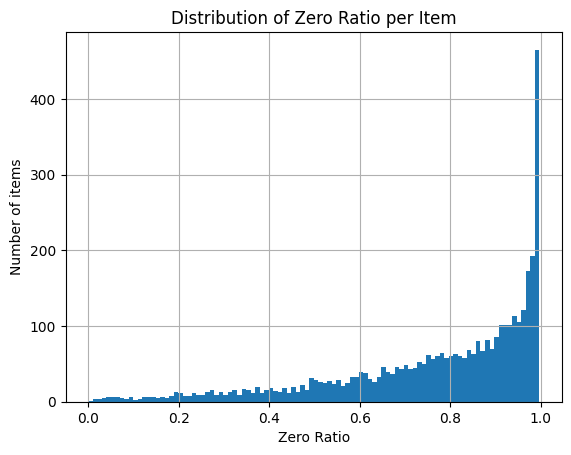

count    3940.000000
mean        0.769630
std         0.224649
min         0.000000
25%         0.652459
50%         0.839344
75%         0.950820
max         0.996721
Name: date, dtype: float64


In [128]:
zero_ratio.hist(bins=100)
plt.xlabel('Zero Ratio')
plt.ylabel('Number of items')
plt.title('Distribution of Zero Ratio per Item')
plt.show()
print(zero_ratio.describe())

In [129]:
day_sell_of_item = df['date'].groupby(sold['item_id']).unique()

In [130]:
items_df = pd.concat([zero_ratio, day_sell_of_item], axis=1)
items_df.columns = ['zero_ratio', 'days_sold']
print(items_df)

         zero_ratio                                          days_sold
item_id                                                               
0.0        0.845902  [12.01.2010, 12.02.2010, 12.03.2010, 12.05.201...
1.0        0.927869  [08.01.2011, 08.02.2011, 11.02.2011, 27.02.201...
2.0        0.921311  [12.03.2010, 12.08.2010, 12.10.2010, 08.02.201...
3.0        0.990164               [12.03.2010, 31.03.2011, 03.04.2011]
5.0        0.983607  [12.06.2010, 17.03.2011, 27.03.2011, 11.06.201...
...             ...                                                ...
4065.0     0.967213  [13.01.2011, 15.02.2011, 08.04.2011, 18.04.201...
4066.0     0.977049  [09.02.2011, 17.02.2011, 18.02.2011, 01.05.201...
4067.0     0.990164               [20.12.2010, 04.04.2011, 27.07.2011]
4068.0     0.986885   [23.12.2010, 05.06.2011, 24.06.2011, 30.06.2011]
4069.0     0.996721                                       [21.12.2010]

[3940 rows x 2 columns]


In [131]:
from src.utils.date_caculator import compute_interarrival
items_df['interarrival'] = items_df['days_sold'].map(compute_interarrival)


In [132]:
items_df['var_demand_days'] = sold['item_cnt_day'].groupby(sold['item_id']).var()
items_df['mean_demand_days'] = sold['item_cnt_day'].groupby(sold['item_id']).mean()
items_df['cv2'] = items_df['var_demand_days'] / (items_df['mean_demand_days'] ** 2)


In [133]:
items_df['ADI'] = items_df['interarrival'].apply(np.mean)

print(items_df['ADI'].describe())

count    3781.000000
mean       24.102703
std        40.360135
min         1.000000
25%         5.117647
50%         9.957143
75%        24.892857
max       565.000000
Name: ADI, dtype: float64


/Users/cps/Library/Caches/pypoetry/virtualenvs/data-science-ecommerce-cOQ0u3NZ-py3.11/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning:

Mean of empty slice.

/Users/cps/Library/Caches/pypoetry/virtualenvs/data-science-ecommerce-cOQ0u3NZ-py3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning:

invalid value encountered in scalar divide



In [134]:
q3_adi = items_df["ADI"].quantile(0)
q3_zero_ratio = items_df["zero_ratio"].quantile(0)
q3_cv2 = items_df["cv2"].quantile(0)


filter_items = items_df


print(filter_items.describe())

        zero_ratio  var_demand_days  mean_demand_days          cv2  \
count  3940.000000     3.788000e+03       3940.000000  3788.000000   
mean      0.769630     8.560512e+03         29.691567     3.483736   
std       0.224649     3.710819e+05       1290.464394     7.394929   
min       0.000000     0.000000e+00          1.000000     0.000000   
25%       0.652459     8.333333e+00          2.674731     0.773619   
50%       0.839344     6.377586e+01          5.499554     1.714734   
75%       0.950820     3.518728e+02         10.368421     3.789160   
max       0.996721     2.229064e+07      80995.000000   223.336547   

               ADI  
count  3781.000000  
mean     24.102703  
std      40.360135  
min       1.000000  
25%       5.117647  
50%       9.957143  
75%      24.892857  
max     565.000000  


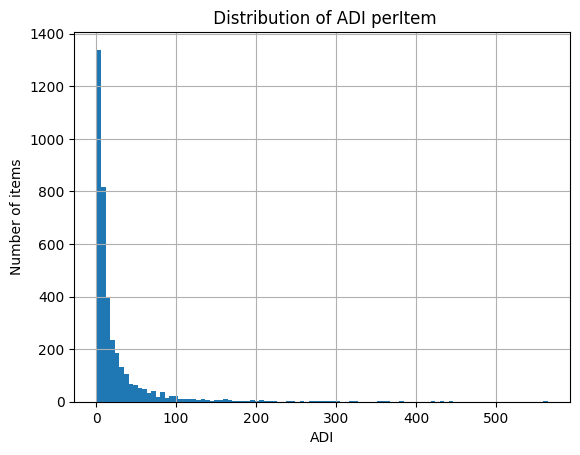

In [135]:
items_df['ADI'].hist(bins=100)
plt.xlabel('ADI')
plt.ylabel('Number of items')
plt.title(' Distribution of ADI perItem')
plt.show()


In [136]:
from src.notebooks.const import name_mapping

df_visual = filter_items[["ADI", "cv2", "zero_ratio"]].dropna().copy()


def label_demand(row, coe_adi=1.32, coe_cv2=0.49, coe_zero_ratio=0.6):
    # Nếu ADI cao hoặc zero_ratio lớn → Intermittent/Lumpy (Gián đoạn)
    if row["ADI"] > coe_adi or row["zero_ratio"] >= coe_zero_ratio:
        # Nếu CV² thấp → Intermittent (Gián đoạn & Ổn định)
        if row["cv2"] < coe_cv2:
            return 2  # Intermittent
        else:
            return 0  # Lumpy (Gián đoạn & Biến động)
    else:
        # Nếu ADI thấp và zero_ratio nhỏ → Smooth/Erratic (Thường xuyên)
        # Bất kể CV² cao hay thấp, trường hợp này đều được gán là Smooth
        return 1  # Smooth (Bao gồm cả Smooth và Erratic)


df_visual["demand_type"] = df_visual.apply(
    lambda x: label_demand(
        x,
        coe_adi=df_visual["ADI"].mean(),
        coe_cv2=df_visual["cv2"].mean(),
        coe_zero_ratio=df_visual["zero_ratio"].mean(),
    ),
    axis=1,
)

print(df_visual["demand_type"].value_counts())

print(df_visual[df_visual["demand_type"] == 2].head())
print(df_visual[df_visual["demand_type"] == 2].describe())
print(df_visual[df_visual["demand_type"] == 2].sample())

demand_type
2    1942
1    1472
0     367
Name: count, dtype: int64
                ADI       cv2  zero_ratio  demand_type
item_id                                               
1.0       15.095238  2.650620    0.927869            2
2.0       27.304348  1.353499    0.921311            2
3.0      193.500000  0.480000    0.990164            2
5.0      104.000000  0.166016    0.983607            2
6.0      198.000000  0.013841    0.986885            2
               ADI          cv2   zero_ratio  demand_type
count  1942.000000  1942.000000  1942.000000       1942.0
mean     40.074885     1.060541     0.915139          2.0
std      50.766969     0.858782     0.068785          0.0
min       1.000000     0.000000     0.760656          2.0
25%      12.221376     0.385466     0.865574          2.0
50%      22.083333     0.854322     0.934426          2.0
75%      47.200000     1.562322     0.976230          2.0
max     565.000000     3.480767     0.993443          2.0
          ADI       cv2  

In [137]:
items_df.to_csv(
    path_converter("/data/processed/items_zero_ratio_days_sold.csv"), index=True
)
df_visual.to_csv(path_converter("/data/features/demand_type.csv"), index=True)

In [138]:
df_filtered = df[df['item_id'] == 1407.0]

24.102703370616776
3.490053030073772
0.7600799510928239


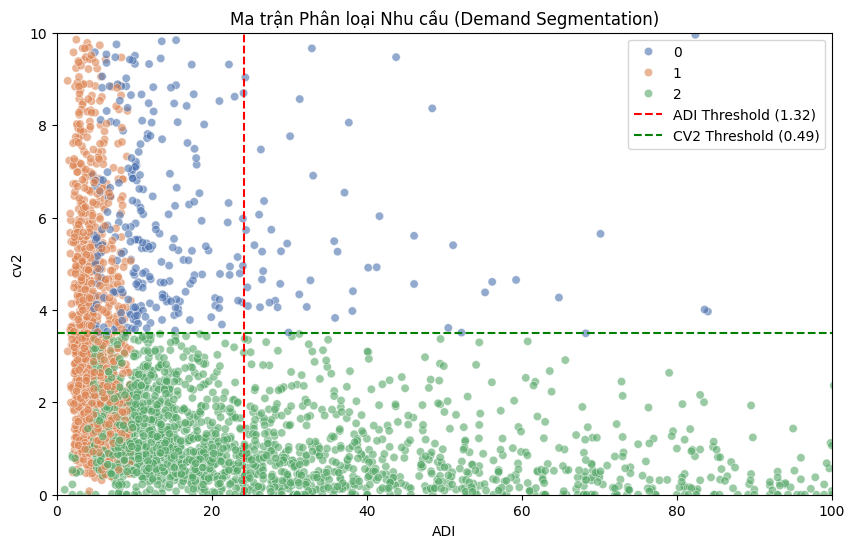

In [139]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_visual, x="ADI", y="cv2", hue="demand_type", alpha=0.6, palette="deep"
)

print(df_visual["ADI"].mean())
print(df_visual["cv2"].mean())
print(df_visual["zero_ratio"].mean())
plt.axvline(
    x=df_visual["ADI"].mean(),
    color="red",
    linestyle="--",
    label="ADI Threshold (1.32)",
)
# plt.axhline(
#     y=df_visual["cv2"].mean(),
#     color="green",
#     linestyle="--",
#     label="CV2 Threshold (0.49)",
# )
plt.axhline(
    y=df_visual["cv2"].mean(),
    color="green",
    linestyle="--",
    label="CV2 Threshold (0.49)",
)
plt.title("Ma trận Phân loại Nhu cầu (Demand Segmentation)")
plt.xlim(0, 100)
plt.ylim(0, 10)
plt.legend()
plt.show()

In [140]:
import plotly.express as px

df_visual["demand_type_name"] = df_visual["demand_type"].map(name_mapping)

# Vẽ 3D scatter Plotly
fig = px.scatter_3d(
    df_visual,
    x="ADI",
    y="cv2",
    z="zero_ratio",
    color="demand_type_name",  # dùng cột tên loại demand
    labels={
        "ADI": "ADI",
        "cv2": "CV²",
        "zero_ratio": "Zero Ratio",
        "demand_type_name": "Demand Type"
    },
    title="Interactive 3D Segmentation for Intermittent Demand"
)

# Không cần hover
fig.update_traces(hoverinfo="skip", hovertemplate=None)

# Marker nhỏ, trong suốt vừa phải
fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(legend_title_text="Demand Type")

fig.show()
